In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batchSize = 100

transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Lambda(lambda x:x.view(-1))  
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
def D_train(x):
    D.zero_grad()

    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batchSize, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    z = Variable(torch.randn(batchSize, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batchSize, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    D_loss = D_real_loss + D_fake_loss  
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    G.zero_grad()

    z = Variable(torch.randn(batchSize, z_dim).to(device))
    y = Variable(torch.ones(batchSize, 1).to(device)) 

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)
criterion = nn.BCELoss() 
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(batchSize, z_dim).to(device))
    generated = G(test_z)

image_data = generated.view(generated.size(0),1,28,28)
print(image_data.shape)

torch.Size([100, 1, 28, 28])


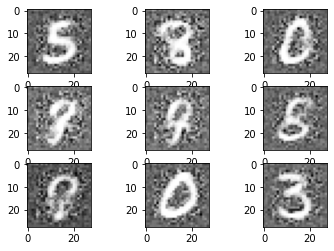

In [ ]:
import matplotlib.pyplot as plt

count=1
for i in range(9):
    imd = image_data[i].view(28,28)
    imd = imd.cpu()

    plt.subplot(3,3,count)
    plt.imshow(imd, cmap=plt.get_cmap('gray'))
    count+=1

plt.show()